## plotting a neuron

In [1]:
import numpy as np
import McNeuron

from keras.models import Sequential
from keras.layers.core import Dense, Reshape
from keras.layers.recurrent import LSTM

import matplotlib.pyplot as plt
from copy import deepcopy
import os

%matplotlib inline

Using Theano backend.


/Users/RoozbehFarhoudi/anaconda/lib/python2.7/site-packages/scipy/sparse/compressed.py:730: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)
/Users/RoozbehFarhoudi/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


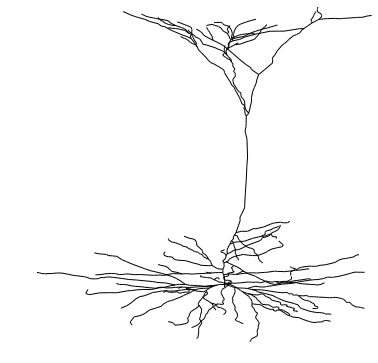

In [2]:
neuron_list = McNeuron.visualize.get_all_path(os.getcwd()+"/Data/Pyramidal/chen")
neuron = McNeuron.Neuron(file_format = 'swc', input_file=neuron_list[19])
McNeuron.visualize.plot_2D(neuron)

In [3]:
#tmp = neuron.subsample_main_nodes()
np.shape(neuron.parent_index)

(1259,)

In [4]:
from numpy import linalg as LA

def random_subsample(neuron, number_random_node):
    """
    randomly select a few number of nodes on the neuron and make a neuron based on that. 
    In the selected nodes, the consecutive nodes on the neuron connects by a stright line.
    Parameters
    ----------
    neuron: Neuron 
    number_random_node: int
        number of nodes to be selected.

    Returns
    -------
        The subsample neuron. 
    """
    I = np.arange(neuron.n_soma, neuron.n_node)
    np.random.shuffle(I)
    selected_index = I[0:number_random_node]
    selected_index = np.union1d(np.arange(neuron.n_soma), selected_index)
    selected_index = selected_index.astype(int)
    selected_index = np.unique(np.sort(selected_index))
    parent_ind = np.array([],dtype = int)
    for i in selected_index:
        p = neuron.parent_index[i]
        while(~np.any(selected_index == p)):
            p = neuron.parent_index[p]
        (ind,) = np.where(selected_index==p)
        parent_ind = np.append(parent_ind, ind)
    n_list = []
    for i in range(selected_index.shape[0]):
        n = McNeuron.Node()
        n.xyz = neuron.nodes_list[selected_index[i]].xyz
        n.r = neuron.nodes_list[selected_index[i]].r
        n.type = neuron.nodes_list[selected_index[i]].type
        n_list.append(n)

    for i in np.arange(1,selected_index.shape[0]):
        j = parent_ind[i]
        n_list[i].parent = n_list[j]
        n_list[j].add_child(n_list[i])
    return McNeuron.Neuron(file_format = 'only list of nodes', input_file = n_list)

def mesoscale_subsample(neuron, number):
    main_point = neuron.subsample_main_nodes()
    Nodes = main_point.nodes_list
    num_rm = (main_point.n_node - number)/2.
    for remove in range(int(num_rm)):
        pair_list = []
        Dis = np.array([])
        for n in Nodes:
            if n.parent is not None:
                if n.parent.parent is not None:
                    a = n.parent.children
                    if(len(a)==2):
                        n1 = a[0]
                        n2 = a[1]
                        if(len(n1.children) == 0 and len(n2.children) == 0):
                            pair_list.append([n1 , n2])
                            dis = LA.norm(a[0].xyz - a[1].xyz,2)
                            Dis = np.append(Dis,dis)
        (b,) = np.where(Dis == Dis.min())
        b = pair_list[b[0]]
        par = b[0].parent
        loc = b[0].xyz + b[1].xyz
        loc = loc/2
        par.children = []
        par.xyz = loc
        Nodes.remove(b[1])
        Nodes.remove(b[0])
        
    return McNeuron.Neuron(file_format = 'only list of nodes', input_file = Nodes)

def reducing_data(swc_df, pruning_number=10):
    """
    Parameters
    ----------
    swc_df: dataframe
        the original swc file
    pruning_number: int
        number of nodes remaining at the end of pruning
        
    Returns
    -------
    pruned_df: dataframe
        pruned dataframe
    
    """
    L = []
    for i in range(len(swc_df)):
        L.append(mesoscale_subsample(McNeuron.Neuron(file_format = 'swc', input_file = swc_df[i]), pruning_number))
    
    return L
    
def separate(list_of_neurons):
    """
    Parameters
    ----------
    list_of_neurons: List of Neurons
        
        
    Returns
    -------
    geometry: array of shape (n-1, 3)
        (x, y, z) coordinates of each shape assuming that soma is at (0, 0, 0)
        
    morphology : array of shape (n-1,)
        index of node - index of parent
    """
    Geo = list()
    Morph = list()
    for n in range(len(list_of_neurons)):
        neuron = list_of_neurons[n]
        Geo.append(neuron.location)
        Morph.append(neuron.parent_index)
    
    return Geo, Morph
    
def geometry_generator(n_nodes=10):
    """
    Generator network: fully connected 2-layer network to generate locations
    
    Parameters
    ----------
    n_nodes: int
        number of nodes
    
    Returns
    -------
    model: keras object
        number of models
    """
    
    model = Sequential()
    
    model.add(Dense(input_dim=100, output_dim=512))
    model.add(Activation('tanh'))

    model.add(Dense(input_dim=512, output_dim=512))
    model.add(Activation('tanh'))

    model.add(Dense(input_dim=512, output_dim=n_nodes * 3))
    model.add(Reshape((n_nodes, 3)))
    
    return model

def morphology_generator(n_nodes=10):
    """
    Generator network: fully connected 2-layer network to generate locations
    
    Parameters
    ----------
    n_nodes: int
        number of nodes
    
    Returns
    -------
    model: keras object
        number of models
    """
    
    model = Sequential()
    
    # A keras seq to seq model, with the following characteristics:
    # input length: 1
    # input dimensionality: 100
    # some hidden layers for encoding
    # some hidden layers for decoding
    # output length: n_nodes - 1
    # output dimensionality: n_nodes - 1 (there will finally be a softmax on each output node)
        
    return model

Number of nodes: 10


McNeuron/visualize.py:758: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  matrix[i,L[i]-1] = 1


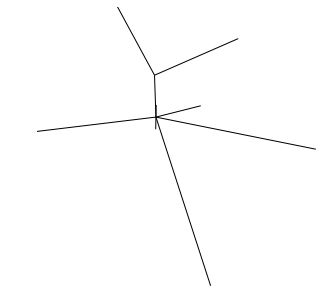

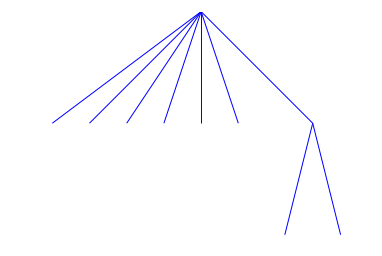

Number of nodes: 40


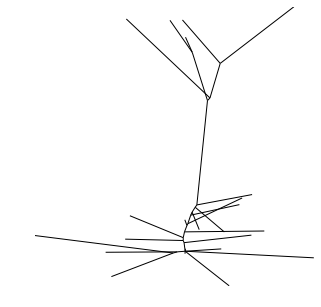

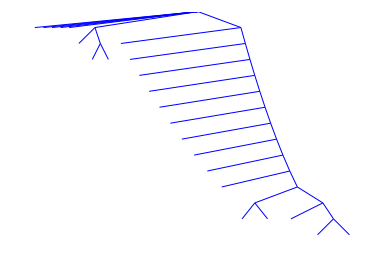

Number of nodes: 70


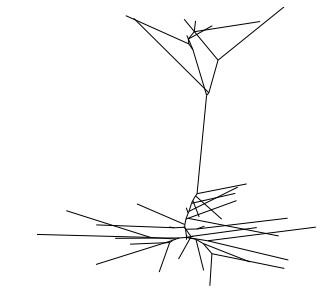

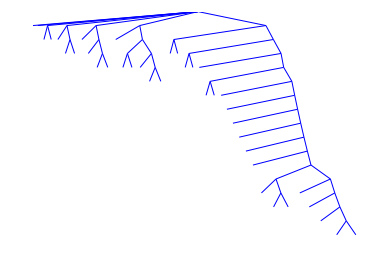

Number of nodes: 100


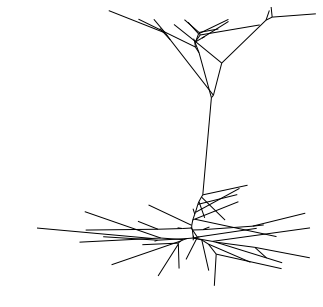

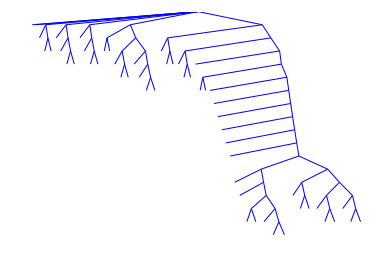

In [5]:
for i in range(4):
    n_nodes = 10 + 30 * i
    subsampled_neuron = mesoscale_subsample(deepcopy(neuron), n_nodes)
    print 'Number of nodes: %d' % (n_nodes)
    McNeuron.visualize.plot_2D(subsampled_neuron, size = 4)
    McNeuron.visualize.plot_dedrite_tree(subsampled_neuron)
    plt.show()

#### Testing function: reducing_data [works]

In [6]:
tmp = reducing_data(neuron_list[0:3], pruning_number=10)

#### Testing function: separate [works]

In [7]:
geo, morph = separate(tmp)

In [8]:
print morph[0]
print morph[1]
print morph[2]

[0 0 0 0 3 3 5 5 0 0 0]
[0 0 0 0 0 0 0 6 7 7 6]
[0 0 0 0 0 0 0 0 7 7]


In [ ]:
geo[2][0:3,9]

#### Testing seq2seq: https://github.com/farizrahman4u/seq2seq [currently does not work]

In [ ]:
import seq2seq
from seq2seq.models import Seq2Seq
from keras.layers.core import Activation

In [ ]:
model = Seq2Seq(input_shape=(100, 1), hidden_dim=100, output_length=11, output_dim=10, depth=2, dropout=0.4)
#model.add(Activation('softmax'))
model.compile(loss='mse', optimizer='rmsprop')

In [ ]:
model.predict(np.random.randn(1, 100, 1))

We may have to write our own dense --> seq with keras layers Dense( ) and LSTM( ).

#### Testing geometry_generator( ) [works]

In [ ]:
ggm = geometry_generator(10)

In [ ]:
tmp = ggm.predict(np.random.randn(5,100))
tmp.shape